# High frequency market data: could you guess the stock?

## Variables

- `obs_id`: This variable identifies which order-book an event is in. For a given `obs_id` all of the events are sequential
- `venue`: This variable identifies the exchange that the order was placed on
- `action`: This variable indicates whether the event is a new order (A), a deleted order (D) or an updated order (U). Note: when a order is completed it is added to the book as a 'D' event. This is a contributing factor to why the `order_id` is complicated.
- `order_id`: This variable encodes a particular event in the order-book; further clarification is still required
- `side`: This variable indicates whether an event is an 'Ask' or a 'Bid'.
- `bid`: This variable refers to the highest price that a buyer is willing to pay for an asset: it does **not** necessarily represent the price of a specific trade order, but rather the highest price out of all current buy orders in the market. Note that this value has been modified by subtracting the best bid price of the first event in the sequence of 100.
- `ask`: This variable refers to the lowest price that a seller is willing to accept for an asset: it does **not** refer to the price of a specific trade order. Note that this value has been modified by subtracting the best bid price of the first event in the sequence of 100.
- `price`: This variable encodes the actual price of one unit of the stock/asset. Note that this value has been modified by subtracting the best bid price of the first event in the sequence of 100. Further clarification on this modification needed - i.e. is it similar to `X[X.obs_id == n].price = X[X.obs_id == n].price - X[X.obs_id == n].bid.max()`
- `flux`: This variable indicates the change in the volume of bid or ask orders in the order-book; this is **not** necessarily the change in volume of the _best_ bid/ask orders. 
- `bid_size`: This variable is a reflection of the current volume of bid orders at the best bid price (given by `bid`) at that moment in time in the order-book
- `ask_size`: This variable is a reflection of the current volume of ask orders at the best ask price (given by `ask`) at that moment in time in the order-book
- `trade`: This variable indicates whether a deletion or update event (indicated in `action`) was due to a trade or due to a cancellation (i.e. all additions should result in deletions later in the book unless the order was unfilled)


## Import the data and libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

In [3]:
X = pd.read_csv("data/X_train.csv")
y = pd.read_csv("data/y_train.csv")

X_submit = pd.read_csv("data/X_test.csv")

# It seems from the data description that obs_id and order_id have been incorrectly swapped 
# Here we correct for this
X["order_id"], X["obs_id"] = X["obs_id"], X["order_id"]
X_submit["order_id"], X_submit["obs_id"] = X_submit["obs_id"], X_submit["order_id"]
y = y.rename(columns={'obs_id':'order_id'})

Convert categorical features to categorical data types for performance optimisation and reduced memory usage.

In [4]:
X["action"] = X["action"].astype("category")
X["side"] = X["side"].astype("category")
X["venue"] = X["venue"].astype("category")
X["obs_id"] = X["obs_id"].astype("category")

In [5]:
X_submit["action"] = X_submit["action"].astype("category")
X_submit["side"] = X_submit["side"].astype("category")
X_submit["venue"] = X_submit["venue"].astype("category")
X_submit["obs_id"] = X_submit["obs_id"].astype("category")

## EDA

In [6]:
print(X.info())
X.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16080000 entries, 0 to 16079999
Data columns (total 12 columns):
 #   Column    Dtype   
---  ------    -----   
 0   obs_id    category
 1   venue     category
 2   order_id  int64   
 3   action    category
 4   side      category
 5   price     float64 
 6   bid       float64 
 7   ask       float64 
 8   bid_size  int64   
 9   ask_size  int64   
 10  trade     bool    
 11  flux      int64   
dtypes: bool(1), category(4), float64(3), int64(4)
memory usage: 935.4 MB
None


,obs_id,venue,order_id,action,side,price,bid,ask,bid_size,ask_size,trade,flux
4306939,33,5,43069,D,A,3.78,0.00,0.02,1220,300,False,-100
1422669,52,2,14226,D,A,0.05,-0.01,0.05,35,500,False,-100
15151219,16,3,151512,D,B,-0.05,0.00,0.04,146,108,False,-2
6817576,55,4,68175,A,B,-0.43,0.00,0.08,100,303,False,100
4548408,6,2,45484,D,B,0.00,0.00,0.02,200,10,False,-100
7938080,51,5,79380,A,B,-0.02,0.00,0.03,553,721,False,92
834427,23,3,8344,D,B,-0.06,0.00,0.05,159,6,False,-58
9322275,59,4,93222,A,A,0.10,0.00,0.02,325,2606,False,100
11224036,27,4,112240,A,A,0.33,0.00,0.07,100,1,False,100
7119957,37,4,71199,A,B,0.00,0.00,0.02,100,600,False,100


First check for null entries:

In [7]:
X.isnull().sum()

obs_id      0
venue       0
order_id    0
action      0
side        0
price       0
bid         0
ask         0
bid_size    0
ask_size    0
trade       0
flux        0
dtype: int64

In [8]:
with pd.option_context("display.precision", 2):
    print(X.describe())

       order_id     price       bid       ask  bid_size  ask_size      flux
count  1.61e+07  1.61e+07  1.61e+07  1.61e+07  1.61e+07  1.61e+07  1.61e+07
mean   8.04e+04  8.81e-01  1.71e-04  5.95e-01  4.30e+02  4.29e+02  2.71e-02
std    4.64e+04  2.18e+02  3.66e-02  1.11e+01  7.40e+02  7.27e+02  1.46e+02
min    0.00e+00 -5.70e+02 -7.60e-01 -3.81e+02 -2.00e+00  1.00e+00 -5.00e+04
25%    4.02e+04 -2.00e-02  0.00e+00  1.00e-02  1.00e+02  1.00e+02 -1.00e+02
50%    8.04e+04  1.00e-02  0.00e+00  4.00e-02  2.23e+02  2.21e+02 -1.00e+00
75%    1.21e+05  9.00e-02  0.00e+00  8.00e-02  5.01e+02  5.00e+02  1.00e+02
max    1.61e+05  2.00e+05  1.62e+01  2.68e+02  8.77e+04  1.50e+05  3.13e+04


Investigating bid, ask and flux features to verify that flux is not associated with bid and ask sizes.

In [9]:
# X[X.side == 'B'].head(100)
X[(X.obs_id == 1)].head(100)
# plt.figure(figsize=(16, 12))
# sns.heatmap(pd.get_dummies(X).corr(), annot=True)

query = (
    (X.obs_id == 1)
    & (X.bid > 0)
    & (X.price > X.bid)
    & (X.action == "A")
    & (X.side == "B")
)
X[query].head(100)

,obs_id,venue,order_id,action,side,price,bid,ask,bid_size,ask_size,trade,flux
2191271,1,5,21912,A,B,121.21,0.05,130.31,1,208,False,100
2191278,1,5,21912,A,B,121.17,0.05,130.31,134,208,False,100
2191298,1,5,21912,A,B,121.18,0.05,130.31,1,208,False,100
2917901,1,4,29179,A,B,135.98,0.01,136.01,100,171,False,100
5037501,1,5,50375,A,B,113.17,0.05,113.27,17,101,False,17
6717566,1,5,67175,A,B,61.52,0.01,61.53,1993,500,False,400
8192017,1,5,81920,A,B,129.56,0.04,140.82,21,2,False,100
8192031,1,5,81920,A,B,129.57,0.04,140.82,21,2,False,100
8192085,1,5,81920,A,B,129.59,0.04,140.82,220,1,False,100
8192093,1,5,81920,A,B,129.57,0.04,140.82,20,1,False,100


Investigating the distribution of flux; if flux was a change in **best** bid/ask prices then we would expect this to be peaked at 0.

<Axes: xlabel='flux', ylabel='Count'>

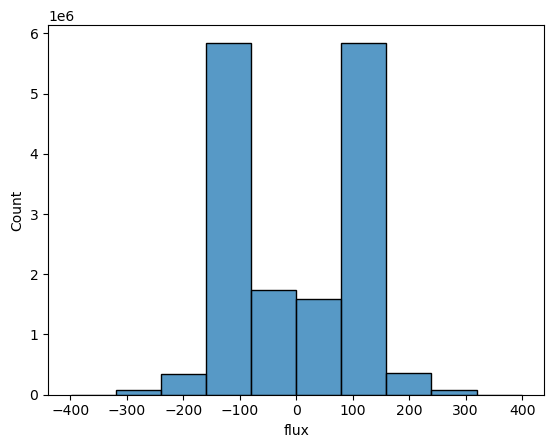

In [10]:
Q1 = X.flux.quantile(0.25)
Q3 = X.flux.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - IQR * 1.5
upper_bound = Q3 + IQR * 1.5

sns.histplot(X[(X.flux < upper_bound) & (X.flux > lower_bound)]["flux"], bins=10)

Question: Why are there 100 values for each order id?

<Axes: xlabel='order_id', ylabel='Count'>

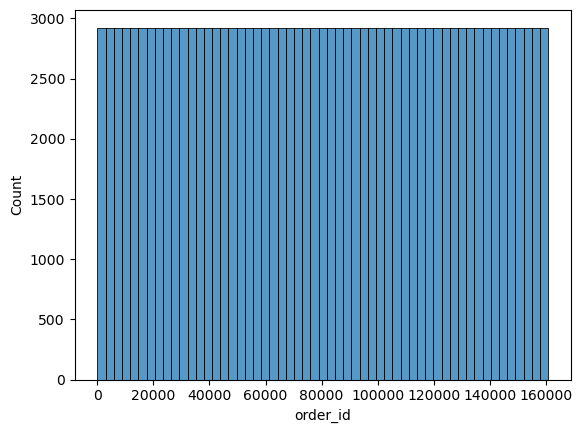

In [11]:
sns.histplot(X.order_id.value_counts().reset_index(), x="order_id")

In [12]:
X.order_id.value_counts()

order_id
0         100
107203    100
107196    100
107197    100
107198    100
         ... 
53600     100
53601     100
53602     100
53603     100
160799    100
Name: count, Length: 160800, dtype: int64

## Models

It appears that the training labels are two orders of magnitude smaller than the training data. Each order id appears only **once** in the labels, whereas it appears 100 times in the training data. Until this mismatch is reconciled we cannot build a supervised learning model.

Here we investigate the data to understand this.

In [17]:
print(X.shape)
print(y.shape)

# y.head()
# print(y.order_id.nunique())
# print(X.order_id.nunique())

# X[X.order_id == 1].sort_values(by='obs_id').head(101)
start, stop = 100, 200
orderid = 50375
# X.iloc[start:stop,2:]
# sns.histplot(X[X.order_id == orderid], x='price', bins=20)
# X.head()

(16080000, 12)
(160800, 2)


In [14]:
y.iloc[0:100]

,order_id,eqt_code_cat
0,0,10
1,1,15
2,2,0
3,3,13
4,4,0
5,5,11
6,6,15
7,7,7
8,8,23
9,9,19


He we guess that the label associated to a given order id will be the label for all observations with that order id. i.e. in the training labels order_id = 0 corresponds to stock (`eqt_code_cat`) 15, so we assign eqt_code_cat 15 to all observations with order_id=0, etc.

For clarity, we are **not** sure whether this is the correct understanding of the dataset.

In [19]:
df = X.copy()
# Merge df with y on 'order_id'
merged_df = pd.merge(df, y[["order_id", "eqt_code_cat"]], on="order_id", how="left")

# Rename the merged 'eqt_code_cat' column if necessary
merged_df.rename(columns={"eqt_code_cat_y": "eqt_code_cat"}, inplace=True)

In [16]:
merged_df.iloc[start:stop]

,obs_id,venue,order_id,action,side,price,bid,ask,bid_size,ask_size,trade,flux,eqt_code_cat
100,0,4,1,A,B,-0.08,0.00,0.04,2,75,False,100,15
101,1,4,1,D,A,0.17,0.00,0.04,2,75,False,-20,15
102,2,4,1,A,A,0.20,0.00,0.04,2,75,False,100,15
103,3,0,1,A,A,0.15,0.00,0.04,2,75,False,100,15
104,4,0,1,A,A,0.15,0.00,0.04,2,75,False,100,15
105,5,0,1,A,A,0.25,0.00,0.04,2,75,False,100,15
106,6,4,1,A,B,-0.01,0.00,0.04,2,75,False,100,15
107,6,4,1,D,B,-0.01,0.00,0.04,2,75,False,-100,15
108,7,4,1,A,B,-0.01,0.00,0.04,2,75,False,100,15
109,8,4,1,D,A,0.06,0.00,0.04,2,75,False,-76,15


In [18]:
target = merged_df.eqt_code_cat
features = merged_df.drop("eqt_code_cat", axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state=49)

### Neural Network

### Support Vector Classifier

### Random forest

### Ensemble methods

Ideas for ensembles:

- XGBoost
- Gradient boosted trees
- Boosting/bagging
- Stacking